In [4]:
## Standard :

# Name imports :
import os
import gc
import copy
import sklearn
import itertools
import time
import typing
import random
import pickle

# Aliased imports :
import multiprocessing as mp
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt

# Partial imports :
from scipy.integrate import quad as integrate
from sklearn.neighbors import KernelDensity
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.utils import check_array

# Full imports :
from plotnine import *

In [57]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)
sb.set_style("dark")

In [6]:
def split(arr: list, count: int) -> typing.List[list]:
    return [arr[i::count] for i in range(count)]

def overlapping_histograms(df: pd.core.frame.DataFrame, 
                           columns: typing.List[str], 
                           names=None, 
                           colors: typing.List[str]=None,
                           labels: typing.Tuple[str]=None
                          ) -> bool:
    """ Create a figure with overlapping histograms and KDEs from 
    a dataframe's specified columns.
    
    df : A pandas.core.frame.DataFrame
    columns : Names of the columns that will be used to construct the histograms.
    names :  Used to label each histogram and KDE, defaults to 'columns'.
    colors :  A list of colors for the histograms. See sb.xkcd_rgb for available colors.
    labels : A tuple containing ('Plot Title', 'xlabel', 'ylabel' )
    
    Returns: 
        True uppon success
        False uppon an error i.e. 
                One of the specified columns isn't found
                on df.columns
    """
    for col in columns:
        if not (col in df.columns):
            return False
    
    if not names:
        names = columns
    
    if not colors:
        colors = [random.choice(list(sb.xkcd_rgb.values())) for i in range(len(columns))]
    
    for column, name, color in zip(columns, names, colors):
        sb.distplot(
            raw[column].dropna(), 
            kde_kws={"color":color,"lw":2,"label":name,"alpha":0.6}, 
            hist_kws={"color":color,"alpha":0.25}
        )
    
    if labels:
        plt.title(labels[0])
        plt.xlabel(labels[1])
        plt.ylabel(labels[2])
    
    return True
    

def select_date_range(df: pd.core.frame.DataFrame, 
                     start_date: str, 
                     end_date: str) -> pd.core.frame.DataFrame:
    """
    """
    mask = (df.index >= start_date) & (df.index <= end_date)
    
    

def time_indexed_df(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Cast into a time-indexed dataframe.
    df1 paramater should contain a column called 'dateTime',
    which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
    """
    _tmp = copy.deepcopy(df1)
    _tmp.index = df1.dateTime
    _tmp.drop('dateTime', axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    gc.collect()
    return _tmp

def merge_date_time(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Take a dataframe containing columns:
        'Date'
        'Time'
        
        And return one containing a single column:
         'dateTime' = 'Date' + 'Time'
        
        For each entry as seen below:
         '2019-03-21 17:34:05' <- '2019-03-21' + '17:34:05'
    """
    _tmp = copy.deepcopy(df1)
    _tmp['dateTime'] = _tmp['Date'] + ' ' + _tmp['Time']
    _tmp.drop(['Date', 'Time'], axis=1, inplace=True)
    gc.collect()
    return _tmp

def hybrid_interpolator(data: pd.core.series.Series,
                        mean: float = None,
                        limit: float = None,
                        methods: typing.List[str] = ['linear', 'spline'], 
                        weights: typing.List[float] = [0.65, 0.35],
                        direction: str = 'forward',
                        order: int = 2
                       ) -> pd.core.series.Series:
    """
    Return a pandas.core.series.Series instance resulting of the weighted average
    of two interpolation methods.
    
    Model:
        φ = β1*method1 + β2*method2
        
    Default:
        β1, β2 = 0.6, 0.4
        method1, method2 = linear, spline
    
    Weights are meant to be numbers from the interval (0, 1)
    which add up to one, to keep the weighted sum consistent.
    
    limit_direction : {‘forward’, ‘backward’, ‘both’}, default ‘forward’
    If limit is specified, consecutive NaNs will be filled in this direction.
    
    If the predicted φ_i value is outside of the the interval
    ( (mean - limit), (mean + limit) )
    it will be replaced by the linear interpolation approximation.
    
    If not set, mean and limit will default to:
        mean = data.mean()
        limit = 2 * data.std()
    
    This function should have support for keyword arguments, but is yet to be implemented.
    """
    predictions: typing.List[float] = [] 
    
    if not np.isclose(sum(weight for weight in weights), 1):
        raise Exception('Sum of weights must be equal to one!')
    
    for met in methods:
        if (met == 'spline') or (met == 'polynomial'):
            predictions.append(data.interpolate(method=met, order=order, limit_direction=direction))
        else:
            predictions.append(data.interpolate(method=met, limit_direction=direction))

    linear: pd.core.series.Series = predictions[0]
    spline: pd.core.series.Series = predictions[1]
    hybrid: pd.core.series.Series = weights[0]*predictions[0] + weights[1]*predictions[1]
    
    corrected: pd.core.series.Series = copy.deepcopy(hybrid) 
    
    if not mean:
        mean = data.mean()
    if not limit:
        limit = 2 * data.std()
    
    for idx, val in zip(hybrid[ np.isnan(data) ].index, hybrid[ np.isnan(data) ]):
        if (val > mean + limit) or (val < mean - limit):
            corrected[idx] = linear[idx]
    
    #df = copy.deepcopy(interpolated)
    #print(df.isnull().astype(int).groupby(df.notnull().astype(int).cumsum()).sum())
    
    return corrected
    
    
def naive_hybrid_interpolator(data: pd.core.series.Series, 
                        methods: typing.List[str] = ['linear', 'spline'], 
                        weights: typing.List[float] = [0.85, 0.15],
                        direction: str = 'both',
                        order: int = 2
                       ) -> pd.core.series.Series:
    """
    Return a pandas.core.series.Series instance resulting of the weighted average
    of two interpolation methods.
    
    Model:
        φ = β1*method1 + β2*method2
        
    Default:
        β1, β2 = 0.6, 0.4
        method1, method2 = linear, spline
    
    limit_direction : {‘forward’, ‘backward’, ‘both’}, default ‘forward’
    If limit is specified, consecutive NaNs will be filled in this direction.
    
    This function should have support for keyword arguments, but is yet to be implemented.
    """
    predictions: typing.List[float] = [] 
    
    if sum(weight for weight in weights) > 1:
        raise Exception('Sum of weights must be equal to one!')
    
    for met in methods:
        if (met == 'spline') or (met == 'polynomial'):
            predictions.append(data.interpolate(method=met, order=order, limit_direction=direction))
        else:
            predictions.append(data.interpolate(method=met, limit_direction=direction))

    #linear = predictions[0]
    #spline = predictions[1]
    
    #print(linear[ np.isnan(data) ])
    
    # working version:
    interpolated = weights[0]*predictions[0] + weights[1]*predictions[1]
    
    #df = copy.deepcopy(interpolated)
    #print(df.isnull().astype(int).groupby(df.notnull().astype(int).cumsum()).sum())
    
    return interpolated
    

def probability_estimate(data: pd.core.series.Series, 
                         start: float, 
                         end: float, 
                         N: int = 150,
                         show_plots=False) -> float:
    """
    """
    
    # Plot the data using a normalized histogram
    dev = copy.deepcopy(data)
    if 'dropna' in dir(dev):
        dev = dev.dropna()
    x = np.linspace(dev.min(), min(data), max(data))[:, np.newaxis]

    # Do kernel density estimation
    kd = KernelDensity(kernel='gaussian', bandwidth=0.85).fit(np.array(dev).reshape(-1, 1))

    # Plot the estimated densty
    kd_vals = np.exp(kd.score_samples(x))

    # Show the plots
    if show_plots:
        plt.plot(x, kd_vals)
        plt.hist(dev, 50, normed=True)
        plt.xlabel('Concentration mg/dl')
        plt.ylabel('Density')
        plt.title('Probability Density Esimation')
        plt.show()

    #probability = integrate(lambda x: np.exp(kd.score_samples(x.reshape(-1, 1))), start, end)[0]
    
    # Integration :
    step = (end - start) / (N - 1)  # Step size
    x = np.linspace(start, end, N)[:, np.newaxis]  # Generate values in the range
    kd_vals = np.exp(kd.score_samples(x))  # Get PDF values for each x
    probability = np.sum(kd_vals * step)  # Approximate the integral of the PDF
    
    return probability


def dev_from_mean(data: pd.core.series.Series) -> typing.Tuple[float, pd.core.series.Series, float]:
    """
    Returns (mean, abs_deviations, avg_of_devs)
    
        mean: float = the mean of the sample
        
        abs_deviations: pandas.core.series.Series = absoulute value of deviations from the mean
        
        avg_of_devs: float = mean of the absolute value of deviations.
    """
    _mean: float = data.mean()
    _std: float = data.std()
    _devs: pd.core.series.Series = np.abs(data - _mean)
    _avg_dev_mean: float = _devs.mean()
        
    return _mean, _std, _devs, _avg_dev_mean


def porcentage_original(serie: pd.core.series.Series, start: str, stop: str) -> float:
    return serie[start:stop].count() / len(serie.loc[start:stop])
    
    
def porcentage_interpolated(serie: pd.core.series.Series, start: str, stop: str) -> float:
    return 1 - porcentage_original(serie, start, stop)


In [7]:
class SVRegressor(object):
    
    def __init__(self, 
                 C: float = 100, 
                 degree: int = 2, 
                 gamma: float = 0.001,
                 epsilon: float = 0.01,
                 X: np.ndarray = None,
                 y: np.ndarray = None,
                 features: str = 'X',
                 labels: str = 'y'
                ):
        """
         Parameter C, gamma and epsilon were set according to a GridSearch.
        """
        self._keys = ['linear', 'poly', 'rbf']   
        self._svrs = {
            'linear': SVR(kernel='linear', C=C), 
            'poly': SVR(kernel='poly', C=C, degree=degree), 
            'rbf': SVR(kernel='rbf', C=C, gamma=gamma, epsilon=0.001)
        }
        self._labels = {
            'features': features, 
            'labels': labels
        }
        if X is not None and y is not None:
            if type(X) is np.ndarray and type(y) is np.ndarray:
                self._X = X
                self._y = y
            else:
                raise Exception('type() X and y should be numpy.ndarray')
        else:
            self._X = X
            self._y = y
    ##
    
    def __getitem__(self, key):
        if key in self.keys:
            return self._svrs[key]
        else:
            raise Exception(f'{key} not found in keys. Possible values are: {self.keys}')
    ##
    
    def load_model(self, filename, kernel=''):
        # load the model from disk
        if kernel in self.kernels:
            self._svrs[kernel] = pickle.load(open(filename, 'rb'))
        else:
            raise Exception(f'Invalid kernel name. Available kernels are: {self.kernels}')
    ##
    
    def GridSearch(self, 
                   param_grid: typing.Dict[str, int],
                   verbose: bool = True,
                   sk_verbose: int = 1,
                   cv: int = 10,
                   n_jobs: int = -1):
        """
            Wrapper for sklearn.model_selection.GridSearchCV
        """
        self._param_grid = param_grid
        search_grid = GridSearchCV(SVR(), self._param_grid, verbose=sk_verbose, cv=cv, n_jobs=n_jobs)
        search_grid.fit(self._X, self._y)
        
        self._best_params = search_grid.best_params_
        self._best_estimator = search_grid.best_estimator_
        
        self._svrs.update({
            'GridSearch': SVR(**self._best_params)
        })
        
        if verbose:
            print("Best Parameters:\n", search_grid.best_params_)
            print("Best Estimators:\n", search_grid.best_estimator_)
    ##
    
    @property
    def keys(self):
        return self._keys
    ##
    
    @property
    def kernels(self):
        return self._keys
    ##
    
    def set_training_data(self, X, y):
        if type(X) is np.ndarray and type(y) is np.ndarray:
            self._X = X
            self._y = y
        else:
            raise Exception('type() X and y should be numpy.ndarray')
    ##
    
    @property
    def training_data(self):
        ''' Returns self._X (features), self._y (labels)'''
        return self._X, self._y
    ##
    
    def fit(self, kernel: str = 'all'):
        if kernel == 'all':
            [ self._svrs[i].fit(self._X, self._y) for i in self.keys ]
        elif kernel in self.kernels:
            self._svrs[kernel].fit(self._X, self._y)
        else:
            raise Exception(f'Invalid kernel, available kernels are {self.kernels}')
    ##
    
    def metrics(self, X: np.ndarray, y: np.ndarray, kernel: str = 'all'):
        if kernel == 'all':
            predictions = { 
                kernel: self._svrs[kernel].predict(X) for kernel in self.kernels
            }
        elif kernel in self.kernels:
            prediction = self._svrs[kernel].predict(X)
            corr       = np.corrcoef(prediction, y)[0][1]
            _devs      = y - prediction
            _abs_devs  = np.abs(_devs)
        else:
            raise Exception(f'Invalid kernel, available kernels are {self.kernels}')
    ##
    
    def MAPE(self, y_true, y_pred): 
        #y_true, y_pred = check_array(y_true, y_pred)
        '''
        Error metrics:
        Mean absolute percentage error.
        Implemented as shown in:
        https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn/294069?fbclid=IwAR1cFYqSCFUjdcM0R0jbUisMuRQ5UgSiZFctNVCdYyFtdZa_ILnMd0stUeU
        '''
        ## Note: does not handle mix 1d representation
        #if _is_1d(y_true): 
        #    y_true, y_pred = _check_1d_array(y_true, y_pred)

        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ##
    
    def MSE(self, X: np.ndarray = None, y: np.ndarray = None, kernel: str = ''):
        '''
        Error metrics:
        Mean squared error.
        Wrapper for sklearn.metrics.mean_squared_error()
        '''
        X = preprocessing.scale(X)
        
        if kernel and kernel in self.kernels:
            predictions = self.predict(kernel=kernel, X=X)
        else:
            raise Exception(f'Invalid kernel {kernel}, available kernels are: {self.kernels}')
        
        return mean_squared_error(y, predictions)
    ##    
    
    def plot(self, X: np.ndarray = None, y: np.ndarray = None, 
             kernel: str = 'all', xlabel: str = 'X', ylabel: str = 'y'):
        
        if X is not None and y is not None:
            X = preprocessing.scale(X)
        else:
            X = self._X
            y = self._y
        
        if kernel == 'all':
            if len(X.shape) == 1:
                plt.scatter(X, y, c='k', label='Data')
                for key, color in zip(self._svrs.keys(), ['g', 'r', 'b']):
                    plt.plot(X, self._svrs[key].predict(X), c=color, label=key)
            else:
                _dummy_x = [i for i in range(len(y))]
                plt.scatter(_dummy_x, y, c='k', label='Data')
                for i, key, color in zip(range(3), self._svrs.keys(), ['g', 'r', 'b']):
                    plt.plot(_dummy_x, self._svrs[key].predict(X), c=color, label=key)
        
        elif kernel in self.kernels:
            if len(X.shape) == 1:
                plt.scatter(X, y, c='k', label='Data')
                plt.plot(X, self._svrs[kernel].predict(X), c='g', label=kernel)
            else:
                _dummy_x = [i for i in range(len(y))]
                plt.scatter(_dummy_x, y, c='k', label='Data')
                plt.plot(_dummy_x, self._svrs[kernel].predict(X), c='g', label=kernel)
        else:
            raise Exception(f'Invalid kernel, available kernels are {self.kernels}')
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title('Support Vector Regression')
        plt.legend()
        plt.show() 
    ##
    
    def scatter(self, X: np.ndarray = None, y: np.ndarray = None, 
             kernel: str = 'all', xlabel: str = 'X', ylabel: str = 'y'):
        
        if X is not None and y is not None:
            X = preprocessing.scale(X)
        else:
            X = self._X
            y = self._y
        
        if kernel == 'all':
            if len(X.shape) == 1:
                plt.scatter(X, y, c='k', label='Data')
                for key, color in zip(self._svrs.keys(), ['g', 'r', 'b']):
                    plt.scatter(X, self._svrs[key].predict(X), c=color, label=key)
            else:
                _dummy_x = [i for i in range(len(y))]
                plt.scatter(_dummy_x, y, c='k', label='Data')
                for i, key, color in zip(range(3), self._svrs.keys(), ['g', 'r', 'b']):
                    plt.scatter(_dummy_x, self._svrs[key].predict(X), c=color, label=key)
        
        elif kernel in self.kernels:
            if len(X.shape) == 1:
                plt.scatter(X, y, c='k', label='Data')
                plt.scatter(X, self._svrs[kernel].predict(X), c='g', label=kernel)
            else:
                _dummy_x = [i for i in range(len(y))]
                plt.scatter(_dummy_x, y, c='k', label='Data')
                plt.scatter(_dummy_x, self._svrs[kernel].predict(X), c='g', label=kernel)
        else:
            raise Exception(f'Invalid kernel, available kernels are {self.kernels}')
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title('Support Vector Regression')
        plt.legend()
        plt.show() 
    ##
    
    def normalize_features(self):
        if type(self._X) is not None:
            self._X = preprocessing.scale(X)
        else:
            raise Exception('Training data not set.')
    ##
    
    def save_model(self, filename, kernel=''):
        if kernel in self.kernels:
            pickle.dump(R[kernel], open(filename, 'wb'))
        else:
            raise Exception(f'Invalid kernel name. Avaailable kernels: {self.kernels}')
    ##
    
    def predict(self, kernel: str = 'all',  X: np.ndarray = None):
        """ Acutal predictions are the first element, to access them:
            SVRegressor.predict()[0]
        """
        if X is None:
            X = self._X
        elif type(X) is not np.ndarray:
            raise Exception('Input type(X), shoud be numpy.ndarray')
        else:
            X = preprocessing.scale(X)
        
        if kernel == 'all':
            return  { 
                kernel: self._svrs[kern].predict(X) for kern in self.kernels 
            }
        elif kernel not in self.kernels:
                raise Exception(f'Kernel not found. Possible values are: all, {self.kernels}')
        else:
            return self._svrs[kernel].predict(X) 
    ##

In [8]:
def data_import(filename: str = 'binaries/first_half_resampled.csv', 
                encoding="utf-8-sig", 
                _index: str = 'grouper') -> typing.Tuple[pd.core.frame.DataFrame, pd.core.indexes.base.Index]:
    """Import data and create a slicer in the simplest way ! """
    
    _data = pd.read_csv(filename, encoding=encoding)
    
    _pool = mp.Pool()
    _data.grouper = _pool.map(pd.to_datetime, _data.grouper)
    _pool.close()
    _pool.terminate()
    
    _data = _data.set_index(_index)
    
    _data['Slope 1min'] = _data['Glucose (t+3)'].diff(periods=1).rolling(window=1).mean()
    _data['Mean Slope 5min'] = _data['Glucose (t+3)'].diff(periods=1).rolling(window=5).mean()
    _data['Total Slope 5min'] = _data['Glucose (t+3)'].diff(periods=1).rolling(window=5).sum()
    _data['Slope Std. Dev,'] = _data['Glucose (t+3)'].diff(periods=1).rolling(window=5).std()
    _data['Max slope'] = _data['Glucose (t+3)'].diff(periods=1).rolling(window=5).max()
    _data['Min slope'] = _data['Glucose (t+3)'].diff(periods=1).rolling(window=5).min()
    _data['Glucose (t+3:15)'] = _data.shift(-15)['Glucose (t+3)']
    _data = _data.dropna()
    
    _slicer = _data.columns[0:-1]
    
    return _data, _slicer
    
    

# Importation de données

In [33]:
data, slicer = data_import()

In [10]:
'dropna' in dir(data)

True

In [11]:
data = data.reset_index().drop('grouper', axis=1)

In [39]:
data.head()

,Glucose (t),Glucose (t+1),Glucose (t+2),Glucose (t+3),Slope 1min,Mean Slope 5min,Total Slope 5min,"Slope Std. Dev,",Max slope,Min slope,Glucose (t+3:15),Glucose (t+3:30)
grouper,,,,,,,,,,,,
2019-01-01 00:05:00,255.0,325.0,258.0,257.0,0.0,0.00,0.0,0.000000,0.0,0.0,196.0,167.0
2019-01-01 00:06:00,256.4,325.2,258.0,255.4,-1.6,-0.32,-1.6,0.715542,0.0,-1.6,193.0,166.0
2019-01-01 00:07:00,257.8,325.4,258.0,253.8,-1.6,-0.64,-3.2,0.876356,0.0,-1.6,190.0,165.0
2019-01-01 00:08:00,259.2,325.6,258.0,252.2,-1.6,-0.96,-4.8,0.876356,0.0,-1.6,187.0,164.0
2019-01-01 00:09:00,260.6,325.8,258.0,250.6,-1.6,-1.28,-6.4,0.715542,0.0,-1.6,184.0,163.0


In [35]:
data['Glucose (t+3:30)'] = data['Glucose (t+3:15)'].shift( -15)

In [36]:
data = data.dropna()

In [13]:
X = data.loc[1:30240, slicer[0]:slicer[-1]].values
y = data.loc[1:30240, data.columns[-1]].values

In [14]:
X2 = data.loc[30240:35000:, slicer[0]:slicer[-1]].values
y2 = data.loc[30240:35000, data.columns[-1]].values

In [15]:
X3 = data.loc[35000:40000:, slicer[0]:slicer[-1]].values
y3 = data.loc[35000:40000, data.columns[-1]].values

In [16]:
X4 = data.loc[35000:35000+1500, slicer[0]:slicer[-1]].values
y4 = data.loc[35000:35000+1500, data.columns[-1]].values

In [17]:
R = SVRegressor()

In [18]:
R.set_training_data(X, y)

In [19]:
R.normalize_features()

In [20]:
### To measure execution time (this method might not be very accurate, use with precaution)
start = time.clock()
R.fit(kernel='rbf')
elapsed = time.clock()
print(f'{elapsed - start}')

52.638707


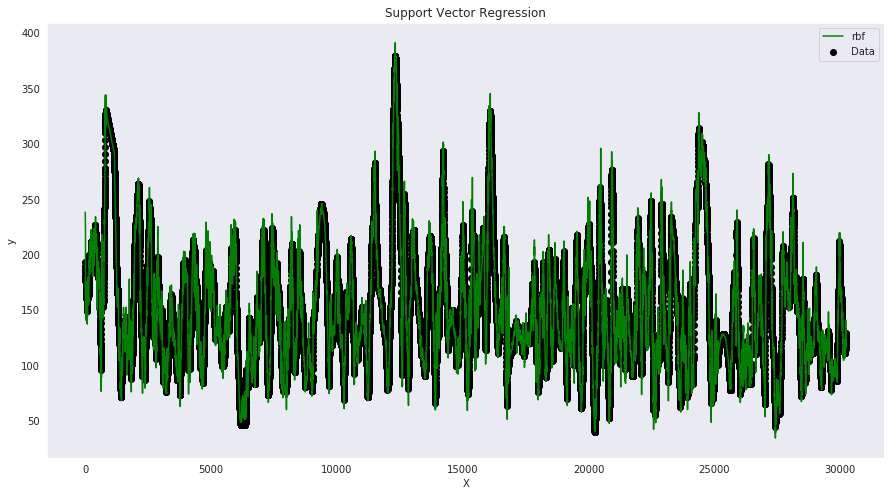

In [21]:
R.plot(kernel='rbf')

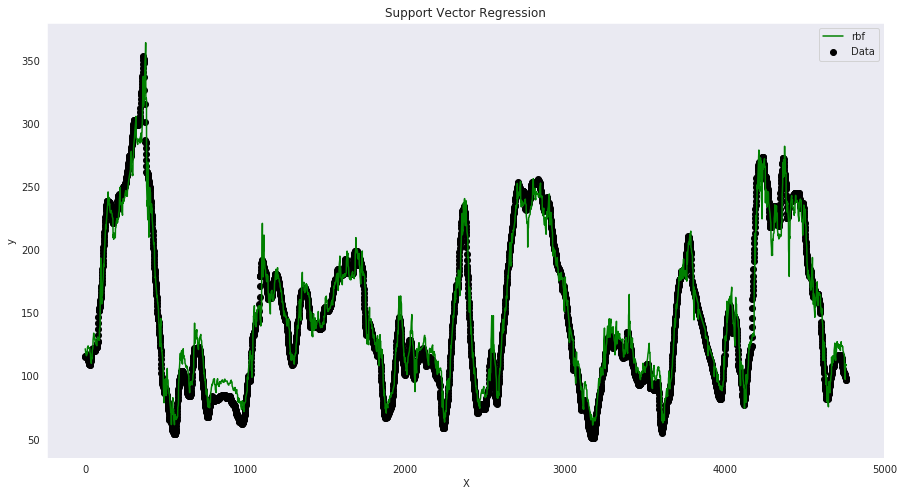

In [22]:
R.plot(X=X2, y=y2, kernel='rbf')

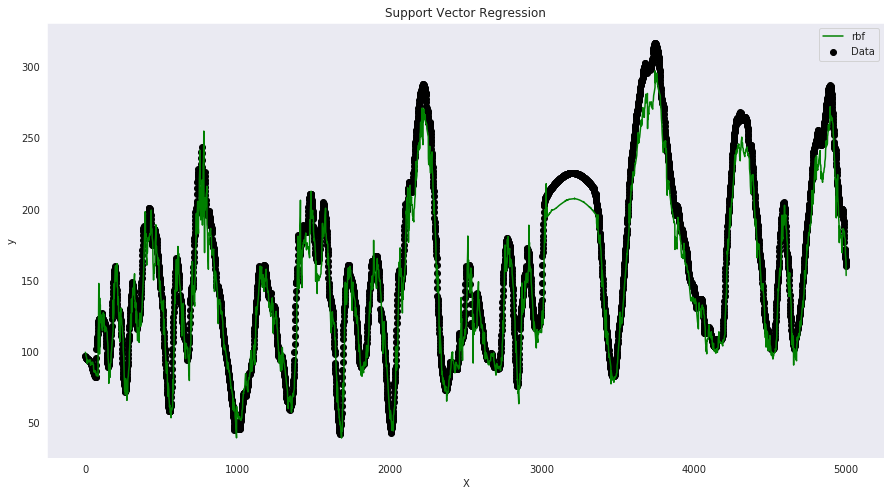

In [23]:
R.plot(X=X3, y=y3, kernel='rbf')

In [21]:
Z = SVRegressor()

In [22]:
Z.load_model(filename='models/rbf_21days_tseries_model.sav', kernel='rbf')

In [23]:
Z.set_training_data(X, y)
Z.normalize_features()

In [26]:
mean_squared_error(split(y2, 2)[0], Z.predict(kernel='rbf', X=split(X2, 2)[0]))

272.79827708945686

In [27]:
mean_squared_error(y, Z.predict(kernel='rbf', X=X))

70.69370473280436

In [225]:
mean_squared_error(y2, Z.predict(kernel='rbf', X=X2))

272.0313331000548

In [226]:
mean_squared_error(y3, Z.predict(kernel='rbf', X=X3))

282.1570368426161

In [227]:
mean_squared_error(y4, Z.predict(kernel='rbf', X=X4))

818.0555285279536

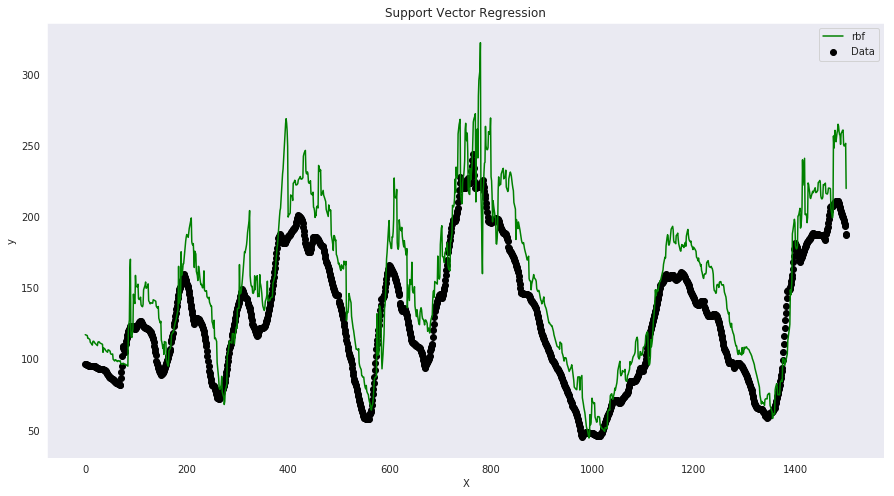

In [28]:
Z.plot(X=X4, y=y4, kernel='rbf')

In [118]:
zpreds = Z.predict(kernel='rbf')

In [120]:
zpreds2 = Z.predict(kernel='rbf', X=X2)

Text(0.5, 1.0, "Distribution des erreurs dans l'ensemble d'entraînement")

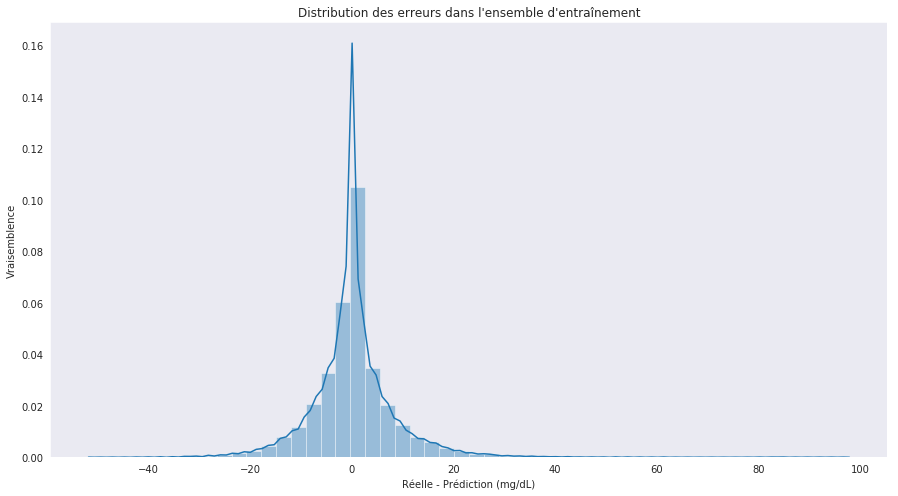

In [119]:
sb.distplot(y-zpreds)
plt.xlabel('Réelle - Prédiction (mg/dL)')
plt.ylabel('Vraisemblence')
plt.title('Distribution des erreurs dans l\'ensemble d\'entraînement')

Text(0.5, 1.0, "Distribution des erreurs dans l'ensemble de vérification")

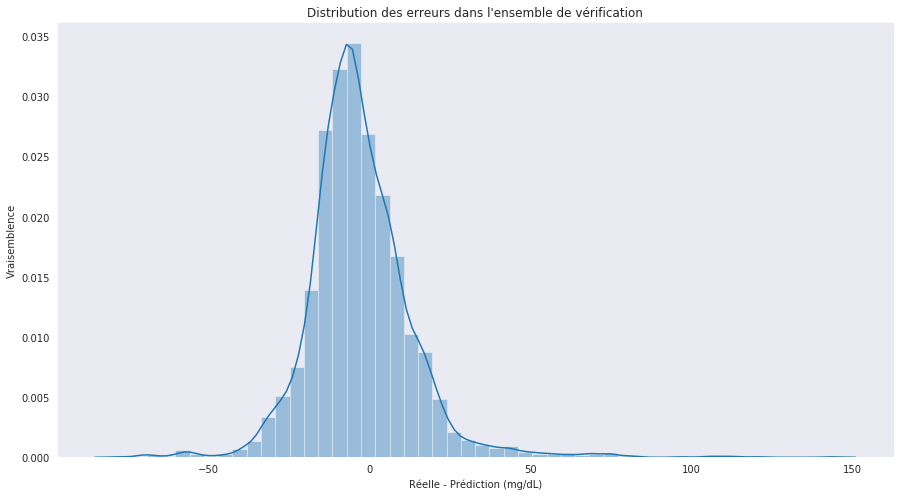

In [121]:
sb.distplot(y2-zpreds2)
plt.xlabel('Réelle - Prédiction (mg/dL)')
plt.ylabel('Vraisemblence')
plt.title('Distribution des erreurs dans l\'ensemble de vérification')

In [129]:
probability_estimate( y2-zpreds2, start=-20, end=20 )

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:214: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


0.8531980234237242

Text(0.5, 1.0, "Distribution de la valeur absolue des erreurs dans l'ensemble de vérification")

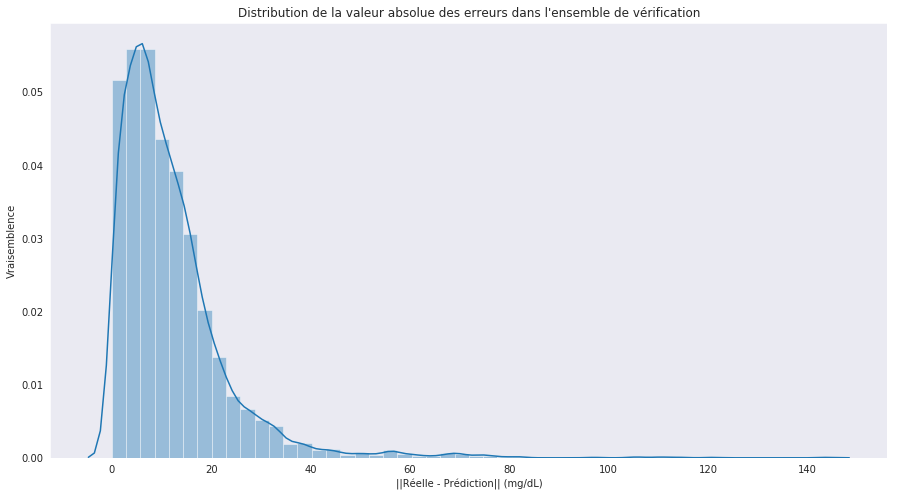

In [128]:
sb.distplot( np.abs(y2-zpreds2) ) 
plt.xlabel('||Réelle - Prédiction|| (mg/dL)')
plt.ylabel('Vraisemblence')
plt.title('Distribution de la valeur absolue des erreurs dans l\'ensemble de vérification')

In [127]:
probability_estimate( np.abs(y2-zpreds2), start=0, end=20 )

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:214: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


0.8368966957535342

# Grid Search

In [63]:
data, slicer = data_import()
X = data.loc['2019/01/01':'2019/01/21', slicer[0]:slicer[-1]].values
y = data.loc['2019/01/01':'2019/01/21', data.columns[-1]].values

In [64]:
GS = SVRegressor()

In [65]:
GS.load_model(filename='models/GridSearch_21j_rbf.sav', kernel='rbf')

In [66]:
GS.set_training_data(X, y)
GS.normalize_features()

In [67]:
#GS.fit()

In [20]:
GS['rbf']

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

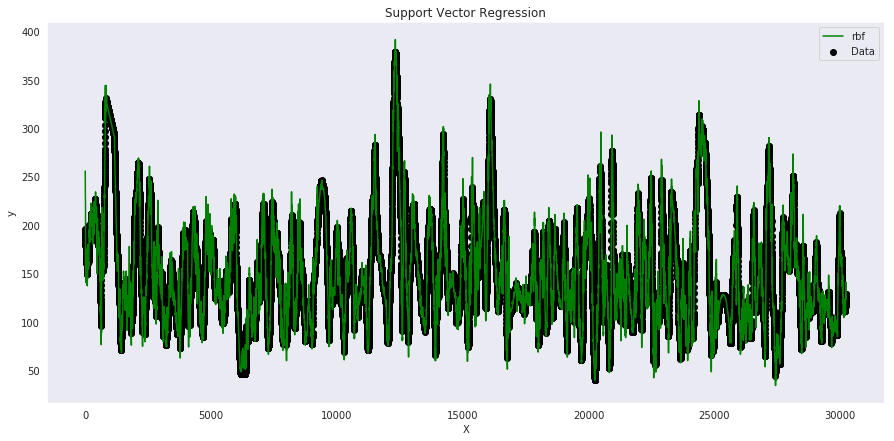

In [21]:
GS.plot(kernel='rbf')

In [68]:
X2 = data.loc['2019/01/11':'2019/01/13', slicer[0]:slicer[-1]].values
y2 = data.loc['2019/01/11':'2019/01/13', data.columns[-1]].values

In [69]:
preds = GS.predict(kernel='rbf')

In [70]:
preds2 = GS.predict(kernel='rbf', X=X2)

Text(0.5, 1.0, "Distribution des erreurs dans l'ensemble d'entraînement")

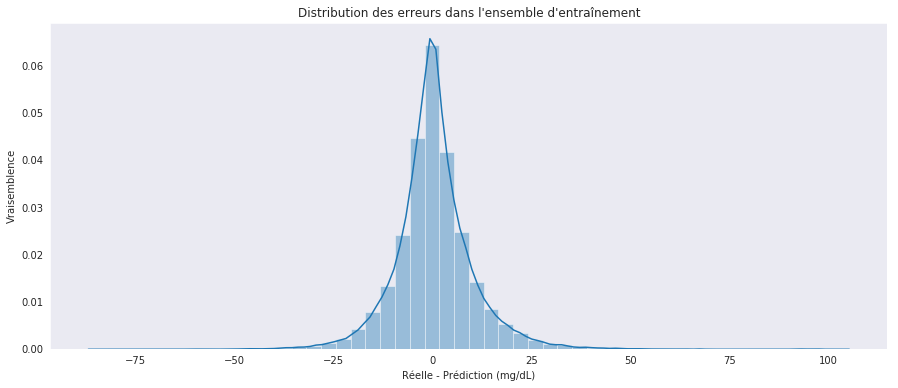

In [71]:
sb.distplot(y-preds)
plt.xlabel('Réelle - Prédiction (mg/dL)')
plt.ylabel('Vraisemblence')
plt.title('Distribution des erreurs dans l\'ensemble d\'entraînement')

In [72]:
probability_estimate(y-preds, -20, 20)

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:214: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


0.943863236803853

Text(0.5, 1.0, "Distribution de la valeur absolue des erreurs dans l'ensemble d'entraînement")

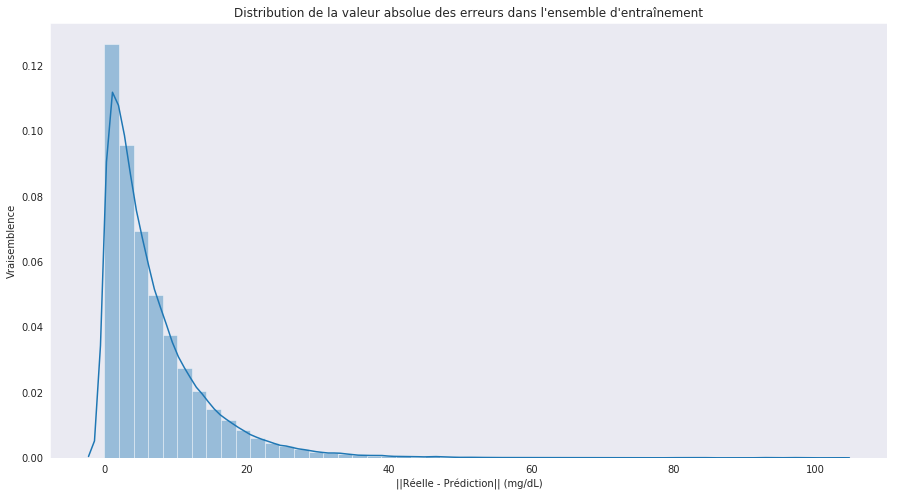

In [85]:
sb.distplot(np.abs(y-preds))
plt.xlabel('||Réelle - Prédiction|| (mg/dL)')
plt.ylabel('Vraisemblence')
plt.title('Distribution de la valeur absolue des erreurs dans l\'ensemble d\'entraînement')

Text(0.5, 1.0, "Distribution des erreurs dans l'ensemble de vérification")

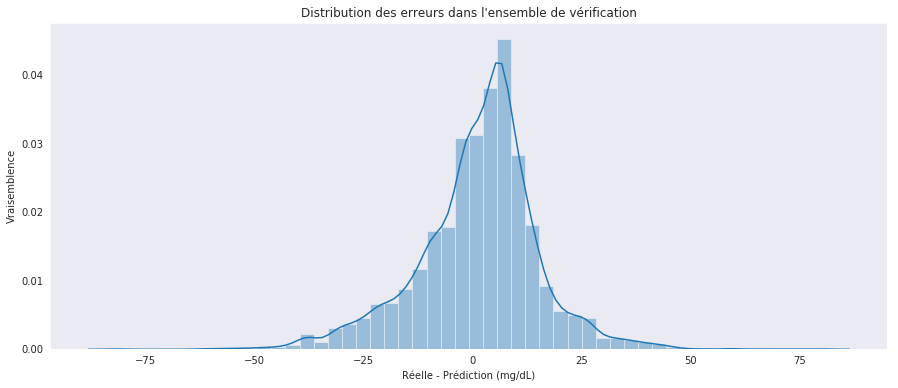

In [74]:
sb.distplot(y2-preds2)
plt.xlabel('Réelle - Prédiction (mg/dL)')
plt.ylabel('Vraisemblence')
plt.title('Distribution des erreurs dans l\'ensemble de vérification')

In [73]:
probability_estimate( y2-preds2, start=-20, end=20 )

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:214: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


0.8620534862090079

Text(0.5, 1.0, "Distribution de la valeur absolue des erreurs dans l'ensemble de vérification")

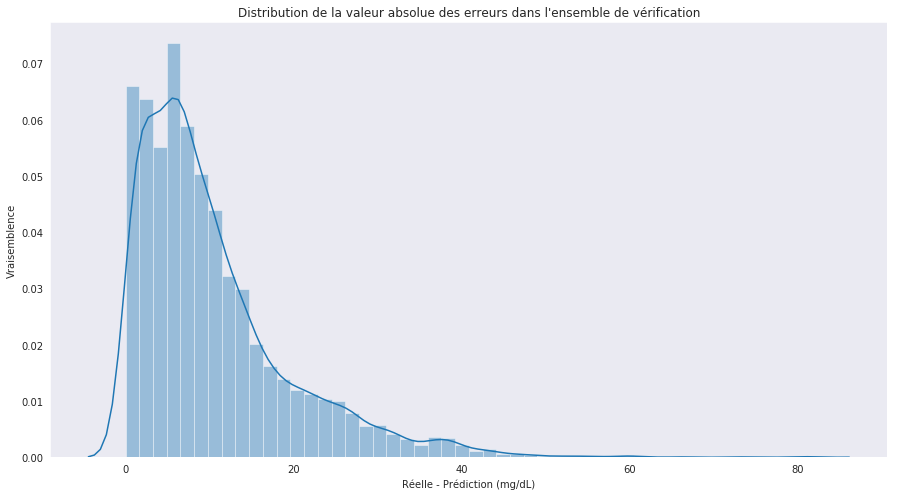

In [88]:
sb.distplot(np.abs(y2-preds2))
plt.xlabel('Réelle - Prédiction (mg/dL)')
plt.ylabel('Vraisemblence')
plt.title('Distribution de la valeur absolue des erreurs dans l\'ensemble de vérification')

In [143]:
probability_estimate( np.abs(y2-preds2), start=0, end=20 )

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:214: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


0.8992292865571571

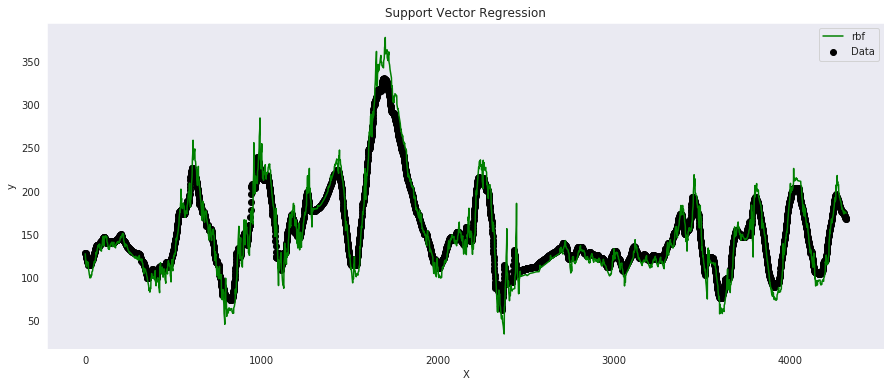

In [75]:
GS.plot(kernel='rbf', X=X2, y=y2)

# Cross Validation

In [43]:
#data.head()

In [151]:
data, slicer = data_import()
X = data.loc['2019/01/01':'2019/03/21', slicer[0]:slicer[-1]].values
y = data.loc['2019/01/01':'2019/03/21', data.columns[-1]].values

In [42]:
slicer

Index(['Glucose (t)', 'Glucose (t+1)', 'Glucose (t+2)', 'Glucose (t+3)',
       'Slope 1min', 'Mean Slope 5min', 'Total Slope 5min', 'Slope Std. Dev,',
       'Max slope', 'Min slope'],
      dtype='object')

In [44]:
X = data.loc['2019/01/01':'2019/03/11', slicer[0]:slicer[-1]].values
y = data.loc['2019/01/01':'2019/03/11', data.columns[-1]].values

In [ ]:
GS

In [23]:
#optimum = cross_val_score(GS['rbf'] , X, y, scoring='accuracy', cv = 15, n_jobs=-1)

In [24]:
#print(f'Cross validation scores: \nMin: {optimum.min()}, Mean: {round(optimum.mean(),3)}, Max: {optimum.max()}')

In [49]:
GS.MAPE(y.reshape(-1, 1), GS.predict(kernel='rbf').reshape(-1, 1))

10.63068703903339

In [50]:
GS.MSE(X=X, y=y, kernel='rbf')

413.1018779493761

In [51]:
GS.MAPE(y2.reshape(-1, 1), GS.predict(kernel='rbf', X=X2).reshape(-1, 1))

10.547511747032642

In [52]:
GS.MSE(X=X2, y=y2, kernel='rbf')

231.91784803400336

In [22]:
GS.plot(kernel='rbf', X=X2, y=y2)

NameError: name 'X2' is not defined

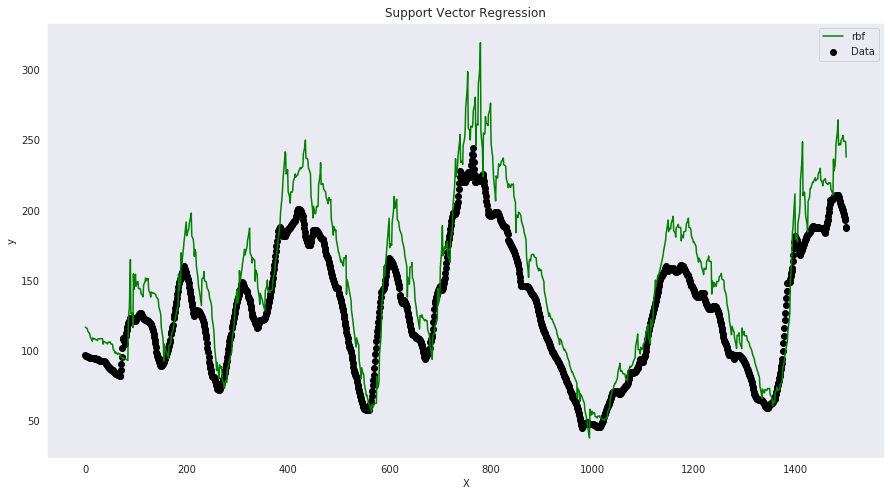

In [114]:
GS.plot(kernel='rbf', X=X4, y=y4)

# Miscellaneous

In [186]:
filename = 'models/rbf_21days_tseries_model.sav'
pickle.dump(R['rbf'], open(filename, 'wb'))

In [351]:
filename = 'models/GridSearch_21j_rbf.sav'
pickle.dump(GS['rbf'], open(filename, 'wb'))

In [55]:
filename = 'models/GridSearch_10j_30min_rbf.sav'
pickle.dump(GS['rbf'], open(filename, 'wb'))

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:214: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


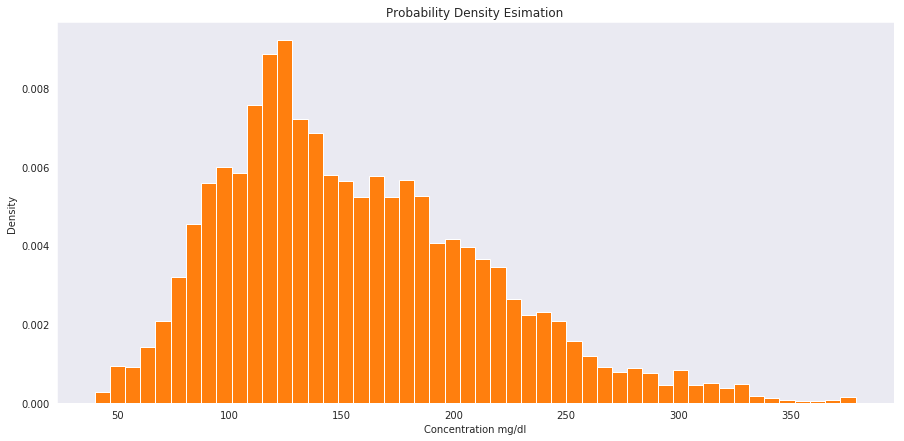

<Figure size 1080x504 with 0 Axes>

In [13]:
x = data['Glucose (t)']
probability_estimate(x, 
                     x.mean() - 2*x.std(), 
                     x.mean() + 2*x.std(),
                     N=500, 
                     show_plots=True
                    )
plt.savefig('hello.png')

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/ipykernel_launcher.py:213: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


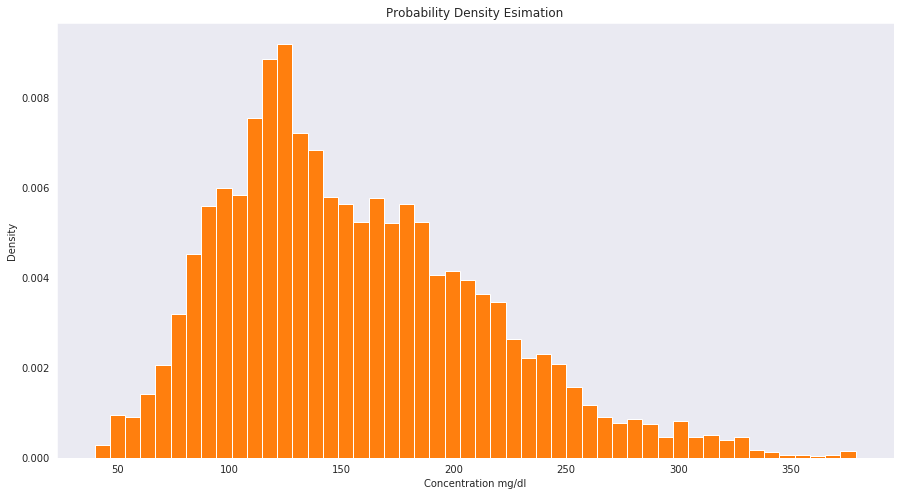

0.43839141688487315

In [24]:
probability_estimate(x, 70, 140, N=500, show_plots=True)

In [25]:
proporciones = (lambda glucosas, borne_inf, borne_sup1, borne_sup2: 
                { 
                    'hypo': (f'x <= {borne_inf}', 100 * glucosas[glucosas <= borne_inf].count() / glucosas.count()),
                    'normo': (f'{borne_inf} < x <= {borne_sup1}', 100 * glucosas[(glucosas > borne_inf) & (glucosas <=borne_sup1)].count() / glucosas.count()),
                    'hyper': (f'x > {borne_sup1}', 100 * glucosas[glucosas > borne_sup1].count() / glucosas.count()),
                    'hyper2': (f'x > {borne_sup2}', 100 * glucosas[glucosas > borne_sup2].count() / glucosas.count()),
                }
)(data['Glucose (t)'], 70, 140, 180)

In [26]:
proporciones

{'hypo': ('x <= 70', 2.937660119555935),
 'normo': ('70 < x <= 140', 43.898377455166525),
 'hyper': ('x > 140', 53.16396242527754),
 'hyper2': ('x > 180', 30.84329632792485)}